# Time Series Analysis of weather data

## Import data packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import TimeSeriesSplit, cross_val_score


## Import data sets

In [374]:
tempelhof = pd.read_csv('/Users/justusweissmuller/Desktop/spiced/week7/ECA_blend_tg/tempelhof.txt', on_bad_lines='skip', sep=",", index_col=2, parse_dates=True)
#stockholm = pd.read_csv('/Users/justusweissmuller/Desktop/spiced/week7/ECA_blend_tg/stockholmm.txt', on_bad_lines='skip', sep=",", index_col=2, parse_dates=True)
#milan = pd.read_csv('/Users/justusweissmuller/Desktop/spiced/week7/ECA_blend_tg/milan.txt', on_bad_lines='skip', sep=",", index_col=2, parse_dates=True)

- STAID: Station Identifier
- SOUD: Source Identifier
- DATE: Date YYYYMMDD
- TG: Mean Temperatur
- Q_TG: Quality Code for TG (0=valid, 1=suspect, 9=missing)

In [375]:
tempelhof.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53538 entries, 1876-01-01 to 2022-07-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   STAID   53538 non-null  int64
 1    SOUID  53538 non-null  int64
 2      TG   53538 non-null  int64
 3    Q_TG   53538 non-null  int64
dtypes: int64(4)
memory usage: 2.0 MB


## Rename Columns

In [376]:
tempelhof.columns

Index(['STAID', ' SOUID', '   TG', ' Q_TG'], dtype='object')

In [377]:
tempelhof = tempelhof.reset_index()

In [378]:
tempelhof = tempelhof.rename(columns={'STAID': 'STAID', ' SOUID': 'SOUID', '    DATE':'DATE','   TG':'TG', ' Q_TG':'Q_TG'})

In [379]:
tempelhof.columns

Index(['DATE', 'STAID', 'SOUID', 'TG', 'Q_TG'], dtype='object')

## Print Data

<AxesSubplot:xlabel='DATE'>

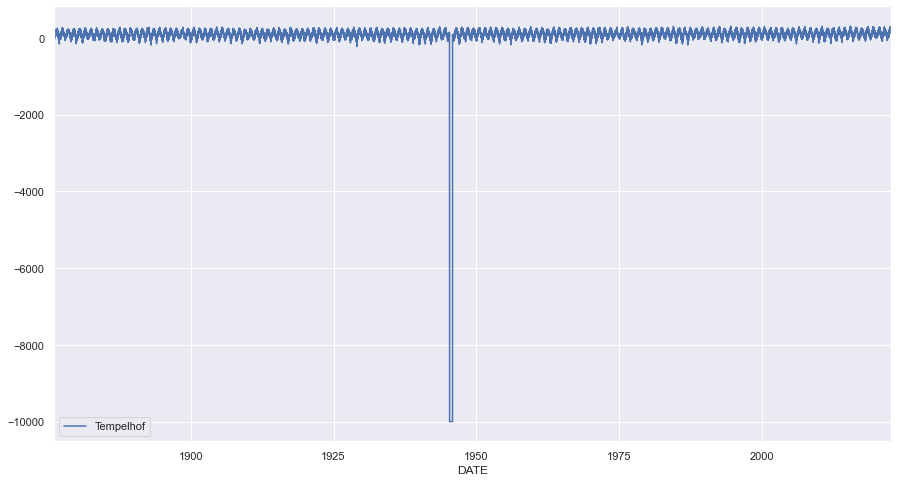

In [380]:
tempelhof.plot(x='DATE', y='TG', label = "Tempelhof")

## Identifing NaNs

In the dataset, NaNs are set to 9 in the Q_TG column, as explained by the downloaded data

In [381]:
tempelhof.loc[tempelhof['Q_TG'] == 9]

,DATE,STAID,SOUID,TG,Q_TG
25316,1945-04-25,2759,27488,-9999,9
25317,1945-04-26,2759,27488,-9999,9
25318,1945-04-27,2759,27488,-9999,9
25319,1945-04-28,2759,27488,-9999,9
25320,1945-04-29,2759,27488,-9999,9
...,...,...,...,...,...
25506,1945-11-01,2759,27488,-9999,9
25507,1945-11-02,2759,27488,-9999,9
25508,1945-11-03,2759,27488,-9999,9
25509,1945-11-04,2759,27488,-9999,9


In [382]:
tempelhof.iloc[25511]

DATE     1945-11-06 00:00:00
STAID                   2759
SOUID                  27488
TG                        78
Q_TG                       0
Name: 25511, dtype: object

## Deletion of data prior to Nov 1945

In [383]:
tempelhof.drop(tempelhof.index[0:25511], inplace = True)

In [384]:
tempelhof

,DATE,STAID,SOUID,TG,Q_TG
25511,1945-11-06,2759,27488,78,0
25512,1945-11-07,2759,27488,68,0
25513,1945-11-08,2759,27488,64,0
25514,1945-11-09,2759,27488,40,0
25515,1945-11-10,2759,27488,46,0
...,...,...,...,...,...
53533,2022-07-27,2759,11448,171,0
53534,2022-07-28,2759,11448,181,0
53535,2022-07-29,2759,11448,220,0
53536,2022-07-30,2759,11448,218,0


## Print of average temperatur over time


Text(0, 0.5, 'Average Temperature')

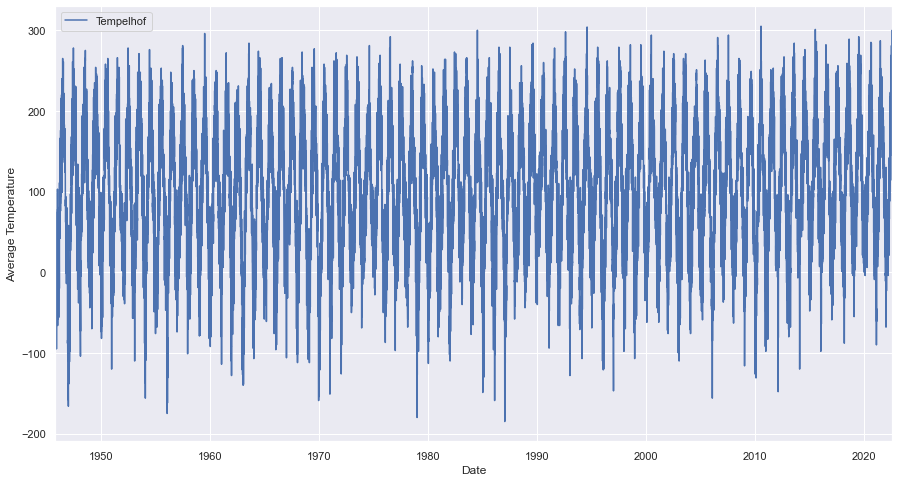

In [385]:
tempelhof.plot(x='DATE', y='TG', label = "Tempelhof")
plt.xlabel('Date')
plt.ylabel('Average Temperature')

## Feature engineering

Goal: Introduce timestamp as well as year and month info to model trend and seasonality

In [386]:
tempelhof.set_index('DATE')

,STAID,SOUID,TG,Q_TG
DATE,,,,
1945-11-06,2759,27488,78,0
1945-11-07,2759,27488,68,0
1945-11-08,2759,27488,64,0
1945-11-09,2759,27488,40,0
1945-11-10,2759,27488,46,0
...,...,...,...,...
2022-07-27,2759,11448,171,0
2022-07-28,2759,11448,181,0
2022-07-29,2759,11448,220,0


In [387]:
tempelhof.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28027 entries, 25511 to 53537
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    28027 non-null  datetime64[ns]
 1   STAID   28027 non-null  int64         
 2   SOUID   28027 non-null  int64         
 3   TG      28027 non-null  int64         
 4   Q_TG    28027 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 1.1 MB


In [388]:
tempelhof['Year'] = tempelhof['DATE'].dt.year
tempelhof['Month'] = tempelhof['DATE'].dt.month
tempelhof['Timestep'] = range(len(tempelhof))
tempelhof.head(5)

,DATE,STAID,SOUID,TG,Q_TG,Year,Month,Timestep
25511,1945-11-06,2759,27488,78,0,1945,11,0
25512,1945-11-07,2759,27488,68,0,1945,11,1
25513,1945-11-08,2759,27488,64,0,1945,11,2
25514,1945-11-09,2759,27488,40,0,1945,11,3
25515,1945-11-10,2759,27488,46,0,1945,11,4


## Train Test Split

- Split tempelhof data set into training data set and testing data set

In [389]:
tempelhof_train = tempelhof[:-365]
tempelhof_test = tempelhof[-365:]

## Model the trend

In [390]:
X_train = tempelhof_train[['Timestep']]
y_train = tempelhof_train[['TG']]
X_test = tempelhof_test[['Timestep']]
y_test = tempelhof_test[['TG']]

In [391]:
m_trend = LinearRegression()

In [392]:
m_trend.fit(X_train, y_train)

LinearRegression()

In [393]:
tempelhof_train['trend'] = m_trend.predict(X_train)

/var/folders/py/2yb9z9p52zgfhxcjm27d9nw00000gn/T/ipykernel_2769/1486362452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempelhof_train['trend'] = m_trend.predict(X_train)


In [394]:
tempelhof_test['trend'] = m_trend.predict(X_test)

/var/folders/py/2yb9z9p52zgfhxcjm27d9nw00000gn/T/ipykernel_2769/3703616158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempelhof_test['trend'] = m_trend.predict(X_test)


In [395]:
tempelhof_test

,DATE,STAID,SOUID,TG,Q_TG,Year,Month,Timestep,trend
53173,2021-08-01,2759,11448,182,0,2021,8,27662,107.589954
53174,2021-08-02,2759,11448,176,0,2021,8,27663,107.590627
53175,2021-08-03,2759,11448,178,0,2021,8,27664,107.591300
53176,2021-08-04,2759,11448,185,0,2021,8,27665,107.591972
53177,2021-08-05,2759,11448,187,0,2021,8,27666,107.592645
...,...,...,...,...,...,...,...,...,...
53533,2022-07-27,2759,11448,171,0,2022,7,28022,107.832066
53534,2022-07-28,2759,11448,181,0,2022,7,28023,107.832738
53535,2022-07-29,2759,11448,220,0,2022,7,28024,107.833411
53536,2022-07-30,2759,11448,218,0,2022,7,28025,107.834084


In [396]:
tempelhof_train

,DATE,STAID,SOUID,TG,Q_TG,Year,Month,Timestep,trend
25511,1945-11-06,2759,27488,78,0,1945,11,0,88.986381
25512,1945-11-07,2759,27488,68,0,1945,11,1,88.987054
25513,1945-11-08,2759,27488,64,0,1945,11,2,88.987726
25514,1945-11-09,2759,27488,40,0,1945,11,3,88.988399
25515,1945-11-10,2759,27488,46,0,1945,11,4,88.989072
...,...,...,...,...,...,...,...,...,...
53168,2021-07-27,2759,11448,237,0,2021,7,27657,107.586592
53169,2021-07-28,2759,11448,217,0,2021,7,27658,107.587264
53170,2021-07-29,2759,11448,208,0,2021,7,27659,107.587937
53171,2021-07-30,2759,11448,209,0,2021,7,27660,107.588609


In [397]:
tempelhof_train.columns

Index(['DATE', 'STAID', 'SOUID', 'TG', 'Q_TG', 'Year', 'Month', 'Timestep',
       'trend'],
      dtype='object')

<AxesSubplot:>

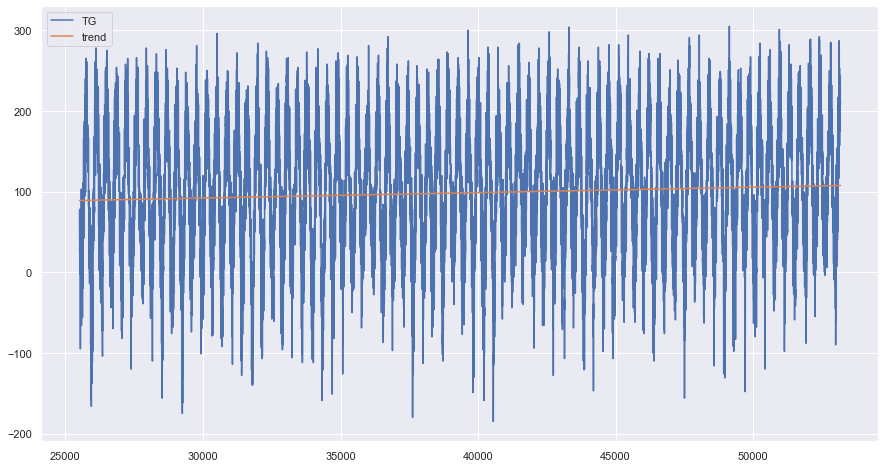

In [398]:
tempelhof_train[['TG', 'trend']].plot()
#tempelhof_train[['trend']].plot()

## Model seasonality

In [399]:
tempelhof_train

,DATE,STAID,SOUID,TG,Q_TG,Year,Month,Timestep,trend
25511,1945-11-06,2759,27488,78,0,1945,11,0,88.986381
25512,1945-11-07,2759,27488,68,0,1945,11,1,88.987054
25513,1945-11-08,2759,27488,64,0,1945,11,2,88.987726
25514,1945-11-09,2759,27488,40,0,1945,11,3,88.988399
25515,1945-11-10,2759,27488,46,0,1945,11,4,88.989072
...,...,...,...,...,...,...,...,...,...
53168,2021-07-27,2759,11448,237,0,2021,7,27657,107.586592
53169,2021-07-28,2759,11448,217,0,2021,7,27658,107.587264
53170,2021-07-29,2759,11448,208,0,2021,7,27659,107.587937
53171,2021-07-30,2759,11448,209,0,2021,7,27660,107.588609


In [400]:
tempelhof_train.set_index('DATE', inplace=True)


In [401]:
tempelhof_test.set_index('DATE', inplace=True)

In [402]:
# One-Hot-Encoding the month
seasonal_dummies_train = pd.get_dummies(tempelhof_train.index.month,
                                  prefix='Month',
                                  drop_first=True).set_index(tempelhof_train.index)
seasonal_dummies_train

,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
DATE,,,,,,,,,,,
1945-11-06,0,0,0,0,0,0,0,0,0,1,0
1945-11-07,0,0,0,0,0,0,0,0,0,1,0
1945-11-08,0,0,0,0,0,0,0,0,0,1,0
1945-11-09,0,0,0,0,0,0,0,0,0,1,0
1945-11-10,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-27,0,0,0,0,0,1,0,0,0,0,0
2021-07-28,0,0,0,0,0,1,0,0,0,0,0
2021-07-29,0,0,0,0,0,1,0,0,0,0,0


In [403]:
seasonal_dummies_test = pd.get_dummies(tempelhof_test.index.month,
                                  prefix='Month',
                                  drop_first=True).set_index(tempelhof_test.index)
seasonal_dummies_test

,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
DATE,,,,,,,,,,,
2021-08-01,0,0,0,0,0,0,1,0,0,0,0
2021-08-02,0,0,0,0,0,0,1,0,0,0,0
2021-08-03,0,0,0,0,0,0,1,0,0,0,0
2021-08-04,0,0,0,0,0,0,1,0,0,0,0
2021-08-05,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-27,0,0,0,0,0,1,0,0,0,0,0
2022-07-28,0,0,0,0,0,1,0,0,0,0,0
2022-07-29,0,0,0,0,0,1,0,0,0,0,0


In [404]:
# join the dummies with the tempelhof data frame
tempelhof_train = tempelhof_train.join(seasonal_dummies_train)
tempelhof_test = tempelhof_test.join(seasonal_dummies_test)

In [405]:
tempelhof_train.head()

,STAID,SOUID,TG,Q_TG,Year,Month,Timestep,trend,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
DATE,,,,,,,,,,,,,,,,,,,
1945-11-06,2759,27488,78,0,1945,11,0,88.986381,0,0,0,0,0,0,0,0,0,1,0
1945-11-07,2759,27488,68,0,1945,11,1,88.987054,0,0,0,0,0,0,0,0,0,1,0
1945-11-08,2759,27488,64,0,1945,11,2,88.987726,0,0,0,0,0,0,0,0,0,1,0
1945-11-09,2759,27488,40,0,1945,11,3,88.988399,0,0,0,0,0,0,0,0,0,1,0
1945-11-10,2759,27488,46,0,1945,11,4,88.989072,0,0,0,0,0,0,0,0,0,1,0


In [406]:
X_train = tempelhof_train.drop(columns=['STAID', 'SOUID', 'TG', 'Q_TG', 'trend'])
X_test = tempelhof_test.drop(columns=['STAID', 'SOUID', 'TG', 'Q_TG', 'trend'])

In [407]:
m_season = LinearRegression()

In [408]:
m_season.fit(X_train,y_train)

LinearRegression()

In [409]:
tempelhof_train['trend + seasonal'] = m_season.predict(X_train)

In [410]:
tempelhof_test['trend + seasonal'] = m_season.predict(X_test)

In [411]:
tempelhof_train.head() 

,STAID,SOUID,TG,Q_TG,Year,Month,Timestep,trend,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend + seasonal
DATE,,,,,,,,,,,,,,,,,,,,
1945-11-06,2759,27488,78,0,1945,11,0,88.986381,0,0,0,0,0,0,0,0,0,1,0,42.341946
1945-11-07,2759,27488,68,0,1945,11,1,88.987054,0,0,0,0,0,0,0,0,0,1,0,42.286407
1945-11-08,2759,27488,64,0,1945,11,2,88.987726,0,0,0,0,0,0,0,0,0,1,0,42.230867
1945-11-09,2759,27488,40,0,1945,11,3,88.988399,0,0,0,0,0,0,0,0,0,1,0,42.175328
1945-11-10,2759,27488,46,0,1945,11,4,88.989072,0,0,0,0,0,0,0,0,0,1,0,42.119789


<AxesSubplot:xlabel='DATE'>

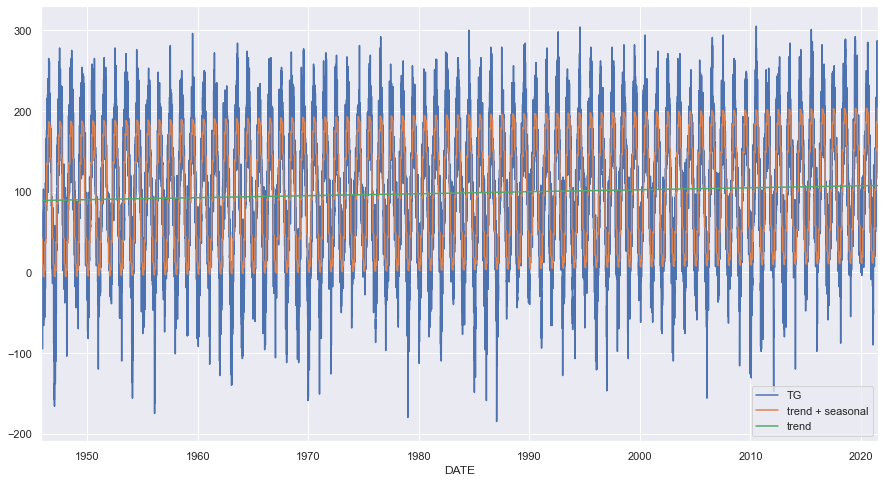

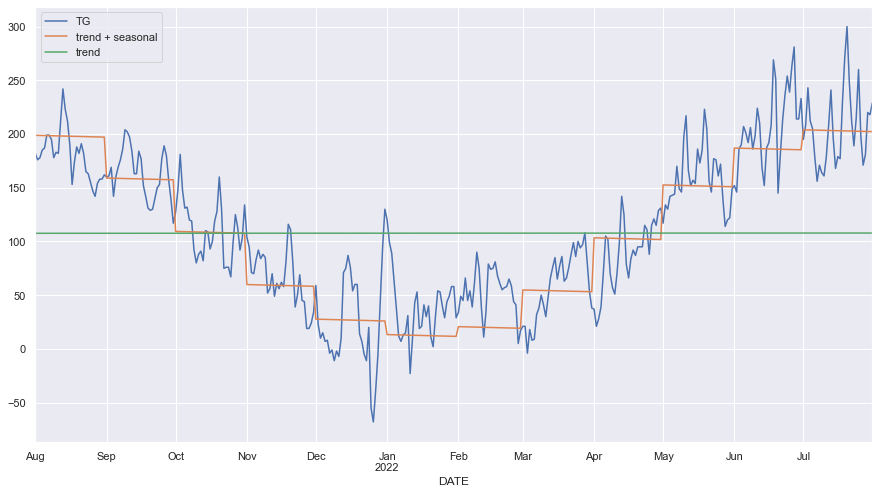

In [412]:
tempelhof_train[['TG', 'trend + seasonal', 'trend']].plot()
tempelhof_test[['TG', 'trend + seasonal', 'trend']].plot()

## Extract Remainder

In [413]:
tempelhof_train['remainder'] = tempelhof_train['TG'] - tempelhof_train['trend + seasonal']
tempelhof_test['remainder'] = tempelhof_test['TG'] - tempelhof_test['trend + seasonal']

<AxesSubplot:xlabel='DATE'>

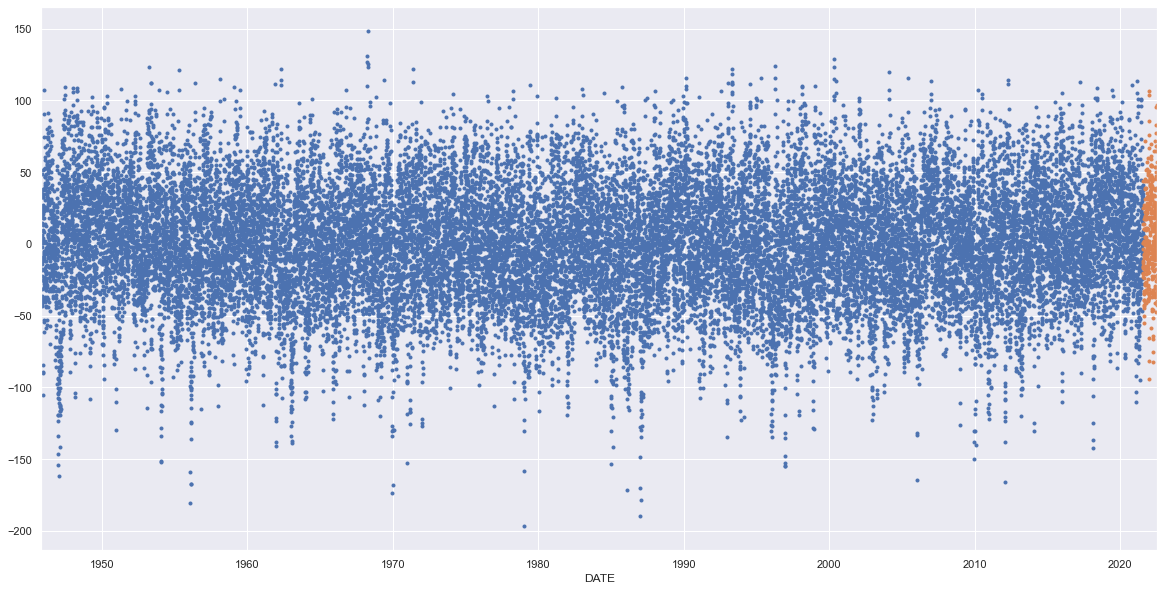

In [414]:
sns.set(rc = {'figure.figsize':(20,10)})
tempelhof_train['remainder'].plot(style='.')
tempelhof_test['remainder'].plot(style='.')

In [415]:
tempelhof_train['lag1'] = tempelhof_train['remainder'].shift(1)
tempelhof_test['lag1'] = tempelhof_test['remainder'].shift(1)
tempelhof_train['lag2'] = tempelhof_train['remainder'].shift(2)
tempelhof_test['lag2'] = tempelhof_test['remainder'].shift(2)

In [416]:
correlation1 = tempelhof_train['remainder'].corr(tempelhof_train['lag1'])
correlation1

0.804951227579764

In [417]:
correlation2 = tempelhof_train['remainder'].corr(tempelhof_train['lag2'])
correlation2

0.599292955341282

<AxesSubplot:xlabel='lag1', ylabel='remainder'>

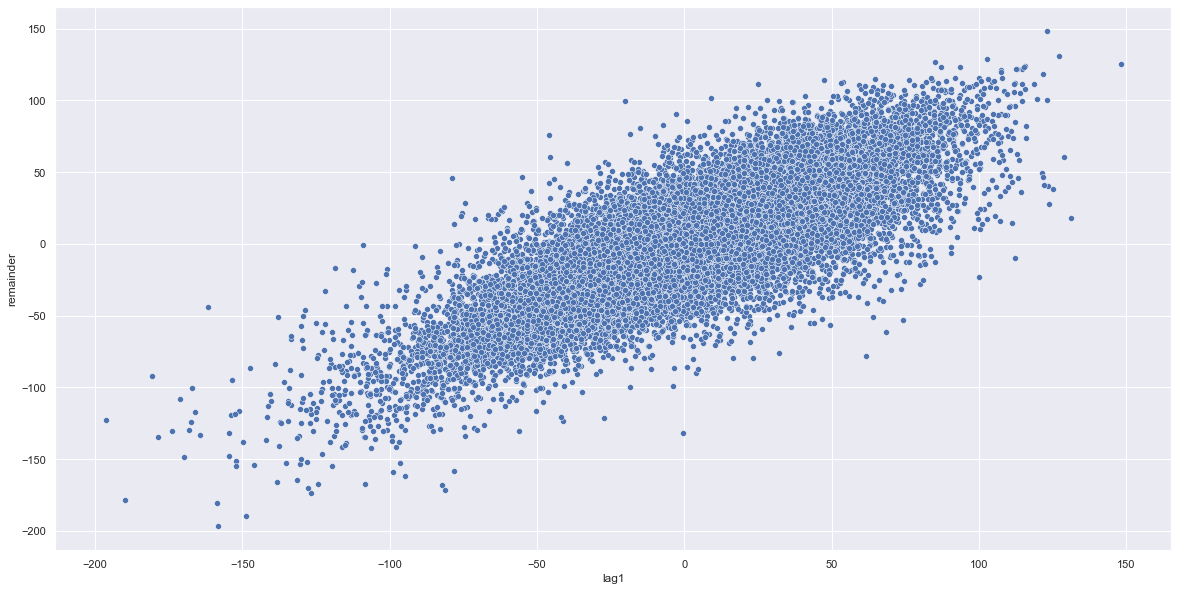

In [418]:
sns.scatterplot(x='lag1', y='remainder', data=tempelhof_train)


<AxesSubplot:xlabel='lag2', ylabel='remainder'>

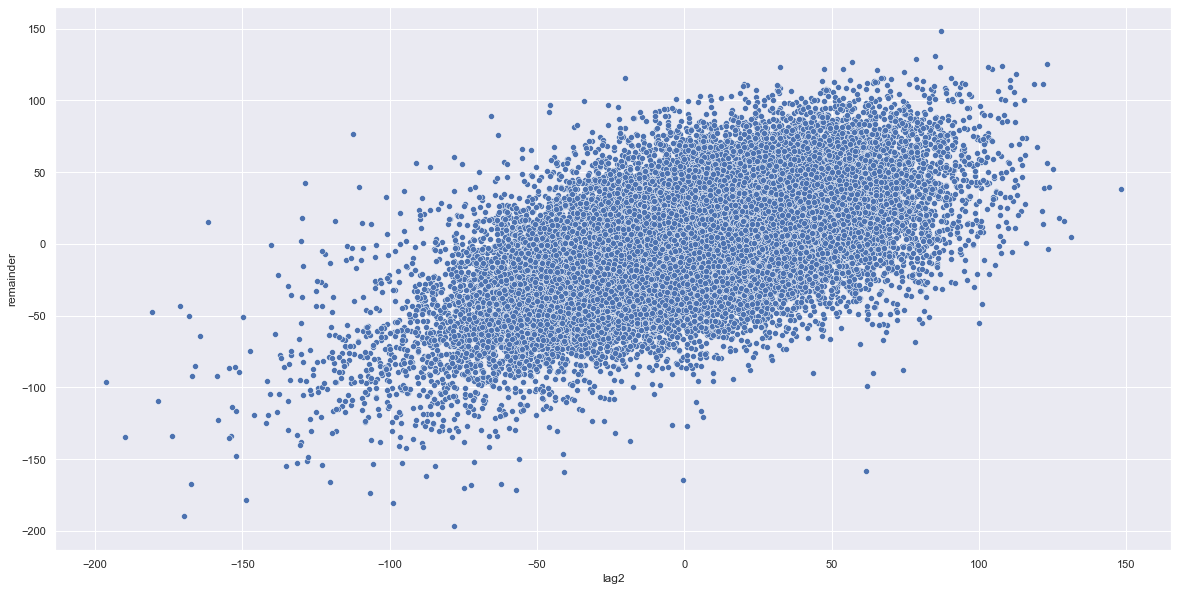

In [419]:
sns.scatterplot(x='lag2', y='remainder', data=tempelhof_train)

## Run an Autoregression (Linear Regression) of lag1 on the remainder

In [420]:
tempelhof_train.head()

,STAID,SOUID,TG,Q_TG,Year,Month,Timestep,trend,Month_2,Month_3,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend + seasonal,remainder,lag1,lag2
DATE,,,,,,,,,,,,,,,,,,,,,
1945-11-06,2759,27488,78,0,1945,11,0,88.986381,0,0,...,0,0,0,0,1,0,42.341946,35.658054,NaN,NaN
1945-11-07,2759,27488,68,0,1945,11,1,88.987054,0,0,...,0,0,0,0,1,0,42.286407,25.713593,35.658054,NaN
1945-11-08,2759,27488,64,0,1945,11,2,88.987726,0,0,...,0,0,0,0,1,0,42.230867,21.769133,25.713593,35.658054
1945-11-09,2759,27488,40,0,1945,11,3,88.988399,0,0,...,0,0,0,0,1,0,42.175328,-2.175328,21.769133,25.713593
1945-11-10,2759,27488,46,0,1945,11,4,88.989072,0,0,...,0,0,0,0,1,0,42.119789,3.880211,-2.175328,21.769133


In [421]:
tempelhof_train.dropna(inplace = True)
tempelhof_train.head()

,STAID,SOUID,TG,Q_TG,Year,Month,Timestep,trend,Month_2,Month_3,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend + seasonal,remainder,lag1,lag2
DATE,,,,,,,,,,,,,,,,,,,,,
1945-11-08,2759,27488,64,0,1945,11,2,88.987726,0,0,...,0,0,0,0,1,0,42.230867,21.769133,25.713593,35.658054
1945-11-09,2759,27488,40,0,1945,11,3,88.988399,0,0,...,0,0,0,0,1,0,42.175328,-2.175328,21.769133,25.713593
1945-11-10,2759,27488,46,0,1945,11,4,88.989072,0,0,...,0,0,0,0,1,0,42.119789,3.880211,-2.175328,21.769133
1945-11-11,2759,27488,30,0,1945,11,5,88.989744,0,0,...,0,0,0,0,1,0,42.064249,-12.064249,3.880211,-2.175328
1945-11-12,2759,27488,28,0,1945,11,6,88.990417,0,0,...,0,0,0,0,1,0,42.008710,-14.008710,-12.064249,3.880211


## How many lags should be included to predict the remainder?


Compute partial autocorrelation to see how many lags should be included

/Users/justusweissmuller/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


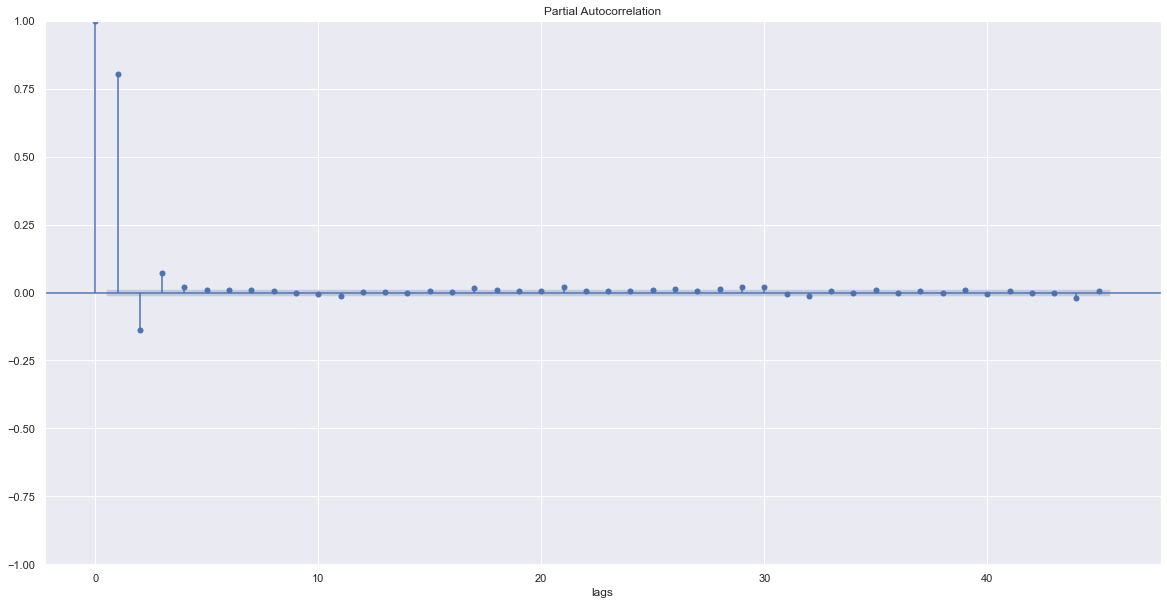

In [422]:

plot_pacf(tempelhof_train['remainder'])
plt.xlabel('lags');

PCF model indicates to include 3 lags

In [423]:
tempelhof_train['lag3'] = tempelhof_train['remainder'].shift(3)
tempelhof_test['lag3'] = tempelhof_test['remainder'].shift(3)

In [424]:
tempelhof_train.head(5)

,STAID,SOUID,TG,Q_TG,Year,Month,Timestep,trend,Month_2,Month_3,...,Month_8,Month_9,Month_10,Month_11,Month_12,trend + seasonal,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,,
1945-11-08,2759,27488,64,0,1945,11,2,88.987726,0,0,...,0,0,0,1,0,42.230867,21.769133,25.713593,35.658054,NaN
1945-11-09,2759,27488,40,0,1945,11,3,88.988399,0,0,...,0,0,0,1,0,42.175328,-2.175328,21.769133,25.713593,NaN
1945-11-10,2759,27488,46,0,1945,11,4,88.989072,0,0,...,0,0,0,1,0,42.119789,3.880211,-2.175328,21.769133,NaN
1945-11-11,2759,27488,30,0,1945,11,5,88.989744,0,0,...,0,0,0,1,0,42.064249,-12.064249,3.880211,-2.175328,21.769133
1945-11-12,2759,27488,28,0,1945,11,6,88.990417,0,0,...,0,0,0,1,0,42.008710,-14.008710,-12.064249,3.880211,-2.175328


In [425]:
tempelhof_train.dropna(inplace = True)
tempelhof_train.head()

,STAID,SOUID,TG,Q_TG,Year,Month,Timestep,trend,Month_2,Month_3,...,Month_8,Month_9,Month_10,Month_11,Month_12,trend + seasonal,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,,
1945-11-11,2759,27488,30,0,1945,11,5,88.989744,0,0,...,0,0,0,1,0,42.064249,-12.064249,3.880211,-2.175328,21.769133
1945-11-12,2759,27488,28,0,1945,11,6,88.990417,0,0,...,0,0,0,1,0,42.008710,-14.008710,-12.064249,3.880211,-2.175328
1945-11-13,2759,27488,24,0,1945,11,7,88.991089,0,0,...,0,0,0,1,0,41.953170,-17.953170,-14.008710,-12.064249,3.880211
1945-11-14,2759,27488,32,0,1945,11,8,88.991762,0,0,...,0,0,0,1,0,41.897631,-9.897631,-17.953170,-14.008710,-12.064249
1945-11-15,2759,27488,30,0,1945,11,9,88.992434,0,0,...,0,0,0,1,0,41.842092,-11.842092,-9.897631,-17.953170,-14.008710


In [426]:
X = tempelhof_train[['lag1', 'lag2', 'lag3']]
y = tempelhof_train[['remainder']]

In [427]:
m_remain = LinearRegression()

In [428]:
m_remain.fit(X,y)

LinearRegression()

In [429]:
tempelhof_train['predictions_ar3'] = m_remain.predict(X)

In [430]:
tempelhof_train.head()

,STAID,SOUID,TG,Q_TG,Year,Month,Timestep,trend,Month_2,Month_3,...,Month_9,Month_10,Month_11,Month_12,trend + seasonal,remainder,lag1,lag2,lag3,predictions_ar3
DATE,,,,,,,,,,,,,,,,,,,,,
1945-11-11,2759,27488,30,0,1945,11,5,88.989744,0,0,...,0,0,1,0,42.064249,-12.064249,3.880211,-2.175328,21.769133,5.628125
1945-11-12,2759,27488,28,0,1945,11,6,88.990417,0,0,...,0,0,1,0,42.008710,-14.008710,-12.064249,3.880211,-2.175328,-12.129761
1945-11-13,2759,27488,24,0,1945,11,7,88.991089,0,0,...,0,0,1,0,41.953170,-17.953170,-14.008710,-12.064249,3.880211,-10.219596
1945-11-14,2759,27488,32,0,1945,11,8,88.991762,0,0,...,0,0,1,0,41.897631,-9.897631,-17.953170,-14.008710,-12.064249,-14.638016
1945-11-15,2759,27488,30,0,1945,11,9,88.992434,0,0,...,0,0,1,0,41.842092,-11.842092,-9.897631,-17.953170,-14.008710,-6.509443


<AxesSubplot:xlabel='Timestep', ylabel='remainder'>

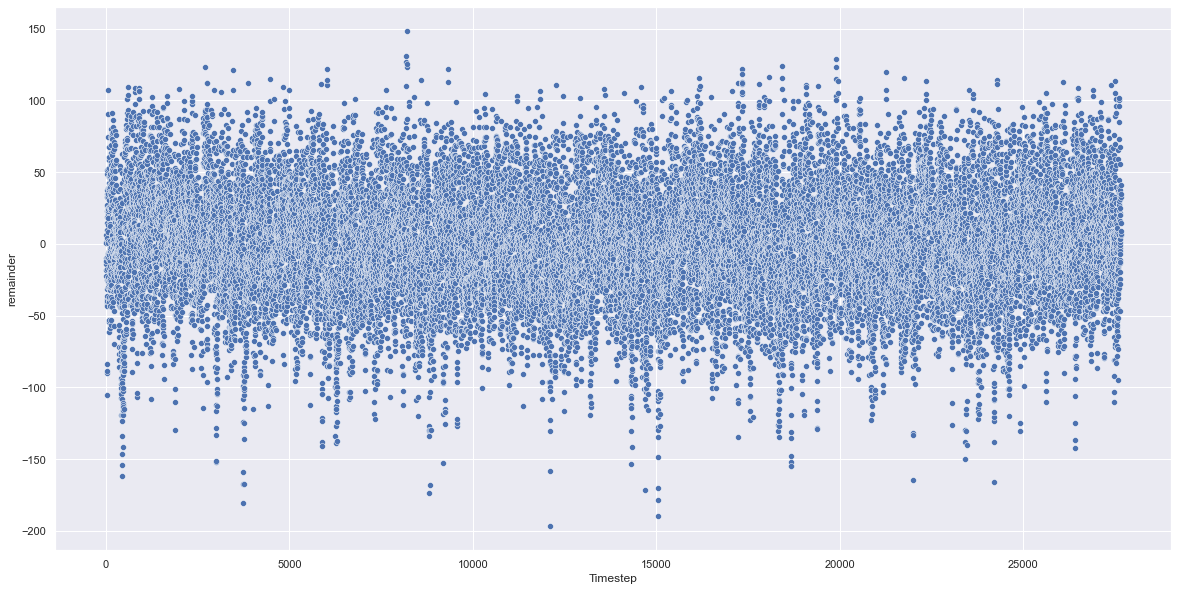

In [431]:
sns.scatterplot(x='Timestep', y='remainder', data=tempelhof_train)

<AxesSubplot:xlabel='DATE'>

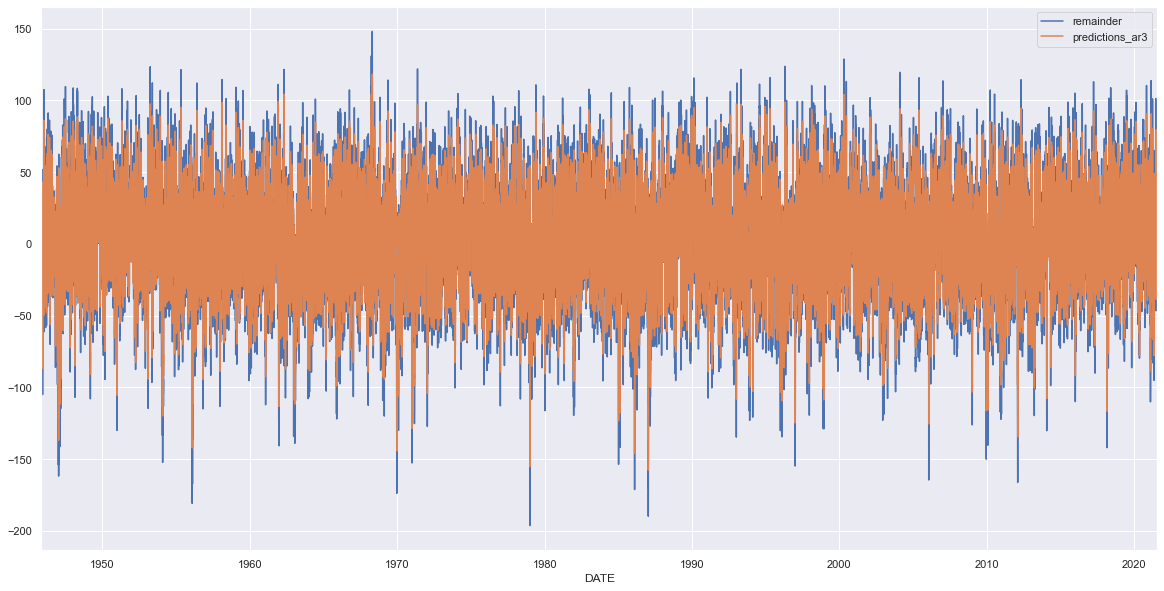

In [432]:
tempelhof_train[['remainder', 'predictions_ar3']].plot()

In [433]:
plot_remainder(tempelhof_train[['remainder', 'predictions_ar3']])

NameError: name 'plot_remainder' is not defined

## Build full model

In [435]:
X_full = tempelhof_train.drop(columns=['TG', 'STAID', 'SOUID', 'Q_TG', 'Year', 'Month', 'trend', 'trend + seasonal', 'remainder', 'predictions_ar3'])

In [436]:
X_full

,Timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,
1945-11-11,5,0,0,0,0,0,0,0,0,0,1,0,3.880211,-2.175328,21.769133
1945-11-12,6,0,0,0,0,0,0,0,0,0,1,0,-12.064249,3.880211,-2.175328
1945-11-13,7,0,0,0,0,0,0,0,0,0,1,0,-14.008710,-12.064249,3.880211
1945-11-14,8,0,0,0,0,0,0,0,0,0,1,0,-17.953170,-14.008710,-12.064249
1945-11-15,9,0,0,0,0,0,0,0,0,0,1,0,-9.897631,-17.953170,-14.008710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-27,27657,0,0,0,0,0,1,0,0,0,0,0,40.711136,32.655596,37.600057
2021-07-28,27658,0,0,0,0,0,1,0,0,0,0,0,34.766675,40.711136,32.655596
2021-07-29,27659,0,0,0,0,0,1,0,0,0,0,0,14.822214,34.766675,40.711136


In [441]:
y_full = y_train.iloc[5: ]


In [442]:
y_full

,TG
25516,30
25517,28
25518,24
25519,32
25520,30
...,...
53168,237
53169,217
53170,208
53171,209


In [444]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [445]:
tempelhof_train

,STAID,SOUID,TG,Q_TG,Year,Month,Timestep,trend,Month_2,Month_3,...,Month_9,Month_10,Month_11,Month_12,trend + seasonal,remainder,lag1,lag2,lag3,predictions_ar3
DATE,,,,,,,,,,,,,,,,,,,,,
1945-11-11,2759,27488,30,0,1945,11,5,88.989744,0,0,...,0,0,1,0,42.064249,-12.064249,3.880211,-2.175328,21.769133,5.628125
1945-11-12,2759,27488,28,0,1945,11,6,88.990417,0,0,...,0,0,1,0,42.008710,-14.008710,-12.064249,3.880211,-2.175328,-12.129761
1945-11-13,2759,27488,24,0,1945,11,7,88.991089,0,0,...,0,0,1,0,41.953170,-17.953170,-14.008710,-12.064249,3.880211,-10.219596
1945-11-14,2759,27488,32,0,1945,11,8,88.991762,0,0,...,0,0,1,0,41.897631,-9.897631,-17.953170,-14.008710,-12.064249,-14.638016
1945-11-15,2759,27488,30,0,1945,11,9,88.992434,0,0,...,0,0,1,0,41.842092,-11.842092,-9.897631,-17.953170,-14.008710,-6.509443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-27,2759,11448,237,0,2021,7,27657,107.586592,0,0,...,0,0,0,0,202.233325,34.766675,40.711136,32.655596,37.600057,33.756856
2021-07-28,2759,11448,217,0,2021,7,27658,107.587264,0,0,...,0,0,0,0,202.177786,14.822214,34.766675,40.711136,32.655596,26.238065
2021-07-29,2759,11448,208,0,2021,7,27659,107.587937,0,0,...,0,0,0,0,202.122246,5.877754,14.822214,34.766675,40.711136,9.570714


In [446]:
tempelhof_train['predictions_full'] = m_full.predict(X_full)
tempelhof_train.head()

,STAID,SOUID,TG,Q_TG,Year,Month,Timestep,trend,Month_2,Month_3,...,Month_10,Month_11,Month_12,trend + seasonal,remainder,lag1,lag2,lag3,predictions_ar3,predictions_full
DATE,,,,,,,,,,,,,,,,,,,,,
1945-11-11,2759,27488,30,0,1945,11,5,88.989744,0,0,...,0,1,0,42.064249,-12.064249,3.880211,-2.175328,21.769133,5.628125,47.584469
1945-11-12,2759,27488,28,0,1945,11,6,88.990417,0,0,...,0,1,0,42.008710,-14.008710,-12.064249,3.880211,-2.175328,-12.129761,29.821343
1945-11-13,2759,27488,24,0,1945,11,7,88.991089,0,0,...,0,1,0,41.953170,-17.953170,-14.008710,-12.064249,3.880211,-10.219596,31.734055
1945-11-14,2759,27488,32,0,1945,11,8,88.991762,0,0,...,0,1,0,41.897631,-9.897631,-17.953170,-14.008710,-12.064249,-14.638016,27.311654
1945-11-15,2759,27488,30,0,1945,11,9,88.992434,0,0,...,0,1,0,41.842092,-11.842092,-9.897631,-17.953170,-14.008710,-6.509443,35.439428


In [447]:
m_full.coef_

array([[ 6.22152594e-04,  7.56787222e+00,  4.16287016e+01,
         8.97481743e+01,  1.38654822e+02,  1.73009195e+02,
         1.90238150e+02,  1.84704552e+02,  1.45331087e+02,
         9.56972427e+01,  4.64954421e+01,  1.42813066e+01,
         9.26179389e-01, -2.05039767e-01,  7.32816873e-02]])

<AxesSubplot:xlabel='DATE'>

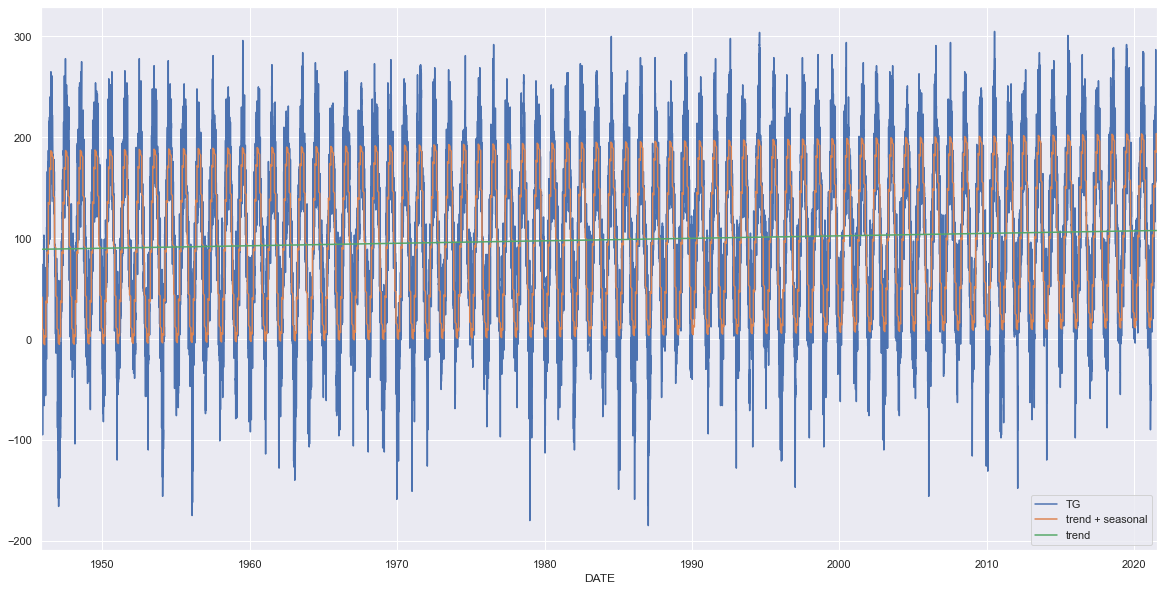

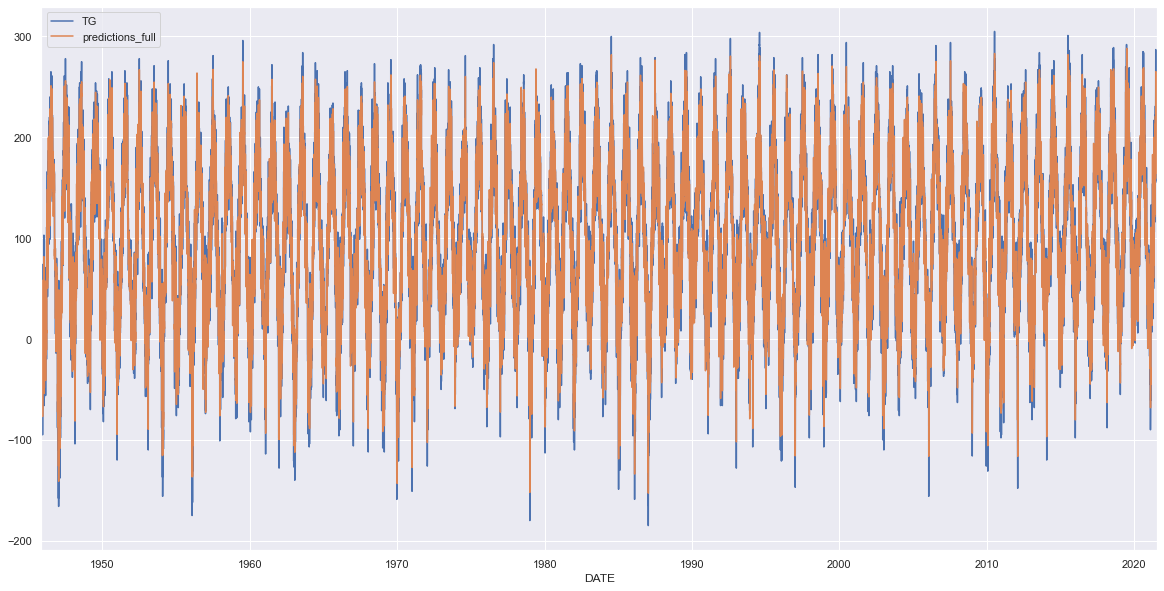

In [451]:
tempelhof_train[['TG', 'trend + seasonal', 'trend']].plot()
tempelhof_train[['TG', 'predictions_full']].plot()

## Test Data

In [453]:
ts_split = TimeSeriesSplit(n_splits=5)

In [454]:
time_series_split = ts_split.split(X_full, y_full) 

In [455]:
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.9153882 , 0.90994102, 0.9055762 , 0.91578532, 0.92102433])

In [456]:
result.mean()

0.9135430161573372